# <img style="float: left; padding-right: 10px; width: 45px" src="iacs.png"> S-109A Introduction to Data Science: 

## Homework 5: Ensemble Methods, and Neural Networks


**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [3]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()

## Assumed Skills:
This assignment presumes knowledge of the following skills:
- Familiarity with sklearn's model objects
- Cross validation to estimate models' future performance
- Booststrapping to build alternative datasets
- Some instruction on Keras' interface for building and training neural networks

Import libraries:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

C:\Users\mkolo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background). 

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: <a href = "https://www.nature.com/articles/ncomms5308">Baldi et al., Nature Communications 5, 2014</a>.

In [5]:
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

In [6]:
data_train.head()

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0


In [7]:
X_train = data_train.iloc[:, data_train.columns != 'class']
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class']
y_test = data_test['class'].values

## Question 1 (12pts): A Single Model
We start by fitting a basic model we can compare the other models to. We'll pick an optimally-tuned decision tree as the base model, because we'll later include random forests and want a fair comparison.

<div class='exercise'> Question 1</div>
** 1.1**  Fit a decision tree model to the training set. Determine the depth-of-tree parameter via 5-fold cross-validation and plot the estimated performance +/- 2 standard deviations for the various depths.

** 1.2** Select an appropriate maximum depth-of-tree, and justify your choice.

**1.3** Report the model's classification accuracy on the test set.

**Answers**:  
**1.1:** Fit a decision tree model to the training set. Determine the depth-of-tree parameter via 5-fold cross-validation and plot the estimated performance +/- 2 standard deviations for the various depths.

In [8]:
# Initialize a Numpy Array
results= np.zeros((10, 5))

# Iterate through depth-of-tree parameters of 1 through 10
for i,n in enumerate(range(1,11)):
    
    # Fit a Decision Tree model with the given depth-of-tree parameter
    tree_model = DecisionTreeClassifier(max_depth=n)
    
    # Store the cross_val_scores in a numpy array of results
    results[i,:] = cross_val_score(tree_model, X_train, y_train, cv=5)

# Conver the numpy array to a pandas dataframe
results_df = pd.DataFrame(results, index=list(range(1,11)), columns= ["CV1","CV2","CV3","CV4", "CV5"])

# Store the mean values of the the cross_val_scores for each depth-of-tree parameter
mean_cvs = np.mean(results, axis=1)

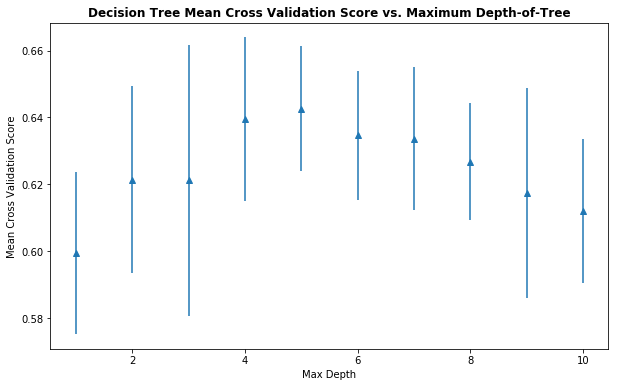

In [9]:
# initialize the figure and subplots
fig, ax = plt.subplots(1,1, figsize=(10,6))

# Store the standard deviations
std_cvs = results_df.std(axis=1).values

# Plot the values
ax.errorbar(results_df.index.values, mean_cvs, 2*std_cvs, linestyle='None', marker='^')

# Add labels
ax.set_title("Decision Tree Mean Cross Validation Score vs. Maximum Depth-of-Tree", fontweight="bold")
ax.set_xlabel("Max Depth")
ax.set_ylabel("Mean Cross Validation Score");

** 1.2** Select an apropriate maximum depth-of-tree, and justify your choice.

----
**After graphing a scatter plot of the mean cross validation scores for decision tree models of depths 1 through 10, a maximum  mean score was found at max_depth=5, which also had a smaller standard deviation than its neigboring depths.  Therefore, this is my choice for the maximum depth-of-tree for my decision tree model.**

----

**1.3** Report the model's classification accuracy on the test set.

In [10]:
# Create DecisionTreeClassifier model with the given max_depth parameter
tree_model = DecisionTreeClassifier(max_depth=5)

# Fir the model to the training data
tree_model.fit(X_train, y_train)

# Store the test predictions of the model
tree_predictions = tree_model.predict(X_test)

# Store the calculated classification accuracy
classification_accuracy =  np.mean(y_test == tree_predictions)

# Print the accuracy scores:
print("\033[1mAccuracy Score\033[0m")
print("\033[1mTest:\033[0m {0: .4f}".format(classification_accuracy))

Accuracy Score
Test:  0.6478


## Question 2 (14 pts): Bagging
Bagging is the technique of building the same model on multiple bootstraps from the data and combining each model's prediction to get an overall classification. In this question we build an example by hand and study how the number of bootstrapped datasets impacts the combined accuracy.

<div class='exercise'> Question 2</div>
**2.1** Create 25 bootstrapped replications of the original training data, and fit a decision tree of depth 5 to each. Record each tree's prediction. In particular, produce a dataset like those below, where each row is a training example, each column is a tree from the forest, and each entry is that tree's prediction for that training example.

`bagging_train`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 25's prediction|
| --- | --- | --- | --- |
|training row 1| binary value | binary value|... |binary value|
|training row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

`bagging_test`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 25's prediction|
| --- | --- | --- | --- |
|test row 1| binary value | binary value|... |binary value|
|test row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

Store these results as `bagging_train` and `bagging_test`.

**2.2** _Aggregate_ all 25 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the 25 models predict that example to be from class 1. Verify that this bagging model scores either 67% or 68% accuracy on the test set.

**2.3** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `sequential_prediction` function to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracy as a function of number of bootstraps.

**2.4** Analyze the graph from 2.3 and discuss the effect of adding more bootstrapped models to the ensemble. What number of trees would you use in a production model to be cost-effective?

**Hints**
- Use `resample` from sklearn to easily bootstrap the x and y data.
- use `np.mean` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?

In [11]:
def running_predictions(prediction_dataset, targets):
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset, where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss,axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

**Answers**:  
**2.1** Create 25 bootstrapped replications of the original training data, and fit a decision tree of depth 5 to each. In particular, produce a dataset similar to 2.1, where each row is a training example, each column is a tree from the forest, but each entry is that tree's prediction of the _probability_ that training example comes from class 1.

In [12]:
# Initialize empty dataframes to store 
bagg_test = pd.DataFrame()
bagg_train = pd.DataFrame()

# Create 25 Bootstrap samples
for i in range(25):
    
    # Store the values of the Bootstrap sample
    boot_X, boot_y = resample(X_train, y_train)
    
    # Fit the sample to a Decision Tree Model
    curr_tree_model = DecisionTreeClassifier(max_depth=5).fit(boot_X, boot_y)
    
    # Store the model's predictions on the test data in the dataframe
    bagg_test["bootstrap model {0}'s predictions".format(i+1)] = curr_tree_model.predict(X_test)

    # Store the model's predictions on the training data in the dataframe
    bagg_train["bootstrap model {0}'s predictions".format(i+1)] = curr_tree_model.predict(X_train)

**2.2** _Aggregate_ all 25 _bootstrapped_ models to get a single meta-prediction for each training and test point: predict a 1 if and only if the average of the 25 models' probability estimates for that point is above .5. Verify that this bagging model scores around 68% classification accuracy on the test set.

In [13]:
# Get predictions
bagg_predictions = round(bagg_test.mean(axis=1))

# Print the accuracy scores:
print("\033[1mAccuracy Score\033[0m")
print("\033[1mTest:\033[0m {0: .4f}".format(np.mean(bagg_predictions == y_test)))

Accuracy Score
Test:  0.6822


**2.3** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `sequential_prediction` function to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracy as a function of number of bootstraps.

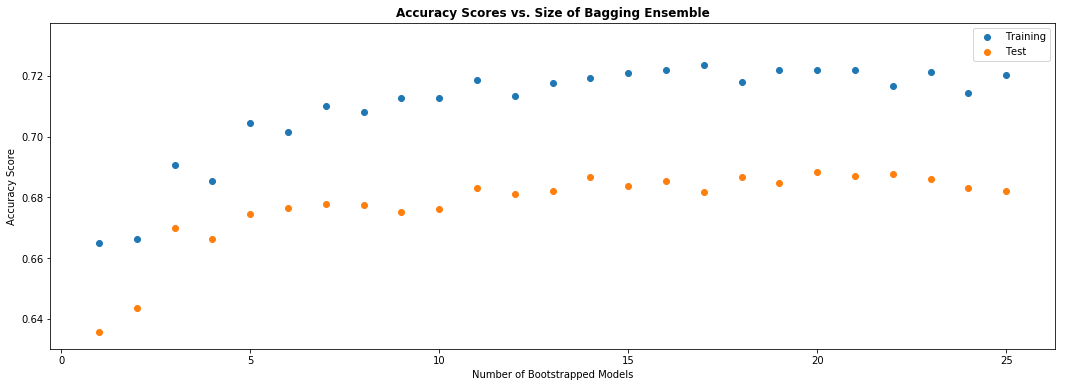

In [14]:

# Initialize figure and plot 
fig, ax = plt.subplots(1,1, figsize=(18,6))

# Plot the Accuracy scores
ax.scatter(np.arange(1,26), running_predictions(bagg_train.values, y_train), label="Training")
ax.scatter(np.arange(1,26), running_predictions(bagg_test.values, y_test), label="Test")

# Add labels
ax.set_title("Accuracy Scores vs. Size of Bagging Ensemble", fontweight="bold")
ax.set_xlabel("Number of Bootstrapped Models")
ax.set_ylabel("Accuracy Score")
ax.legend();

**2.4** Analyze the graph from 2.3 and discuss the effect of adding more bootstrapped models to the ensemble. What number of trees would you use in a production model to be cost-effective?

---

**Initially, adding more bootstrapped models to the ensemble increases the prediction accuracy on both the training and test datasets. However, around a size of nine models the prediction accuracy on the training datasets stops improving consistently and around a size of eleven models the predcition accuracy on the test datasets level off. I would use eleven decision tree models in a production model to be cost-effective, as although the maximum prediction accuracy on the test dataset occurs at around  15 trees, the improvement in accuracy is not as significant as the computational cost to achieve it.**


## Question 3 (6 pts): Random Forests
Random Forests are closely related to the bagging model we built by hand in question 2. In this question we compare our by-hand results with the results of using `RandomForestClassifier` directly.

<div class='exercise'> Question 3</div>
**3.1** Fit a `RandomForestClassifier` to the original `X_train` data using 25 trees and a depth of 5. Comment on the model's test performance compared to the bagging model from Question 2.

**3.2** There are two improvements Random Forests make to the pure boosting approach in Question 2. What are they, and how do they help the random forest model do better than the pure bagging model?

**Hints**:
 - Random forests do not combine each tree's prediction via a majority vote. What do they use instead?

## **Answers**:  
**3.1** Fit a `RandomForestClassifier` to the original `X_train` data using 25 trees and a depth of 5. Comment on the model's test performance compared to the model from Question 2.

In [15]:
# Create the model and fit the training data on it
rf_model = RandomForestClassifier(n_estimators=25, max_depth=5).fit(X_train, y_train)

# Print the accuracy scores:
print("\033[1mAccuracy Score\033[0m")
print("\033[1mTest:\033[0m {0: .4f}".format(np.mean(rf_model.predict(X_test) == y_test)))

Accuracy Score
Test:  0.6860


----
**The model's test performance is almost identical to the to bagging model created in question 2. ** 

----

**3.2** There are two improvements Random Forests make to the pure boosting approach in Question 2. What are they, and how do they help the random forest model do better than the pure bagging model?

**Random Forests are an improvement on the pure bagging approach in Question 2 in that for each tree and at each split a random subset of predictors are selected from the full set of predictors.  These improvements help de-correlate the trees in the forest, which helps combat multi-collinearity.  Also, the Random Forest model is executed in a parallel manner and has a faster run-time than the pure bagging approach in QUestion 2, which is executed iteratively**

## Question 4 (12 pts): Boosting
In this question we explore a counterpart to bagging, where each new model is trained on a dataset weighted towards observations that the current set of models predicts incorrectly. 

We'll focus on the AdaBoost flavor of boosting and examine what happens to the ensemble model's accuracy over the algorithm's run.

<div class='exercise'> Question 4</div>
**4.1** Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 400 iterations. Use the `staged_score` method to help make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.  

**4.2** Repeat the plot above for a base learner with depth in (1,2,3,4). What trends do you see in the training and test accuracy?

**4.3** Based on the plot from 4.2, what combination of base learner depth and number of iterations seems optimal? Why?

**4.4** AdaBoost doesn't combine its sub-models via simple majority vote, or by averaging probabilities. What does it use instead, and why do you think that combination rule was chosen?

**Answers**:  
**4.1** Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 400 iterations. Use the `staged_score` method to help make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

In [16]:
# Initialize the AdaBoostClassifier Model object
ada_model = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth=3), n_estimators=400, learning_rate = 0.05)

# Fit the model to the data
ada_model.fit(X_train, y_train);

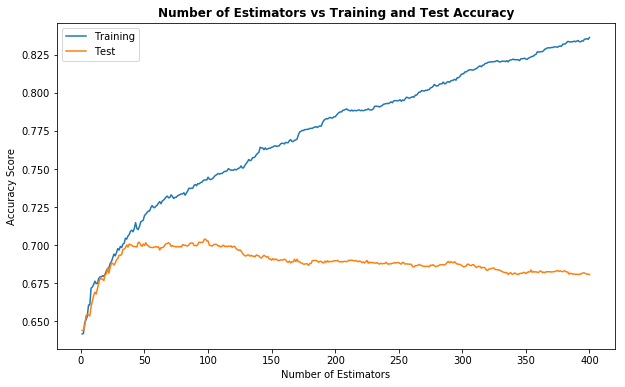

In [17]:
# Initialize figure and subplot
fig, ax = plt.subplots(1,1, figsize=(10,6))

# Plot the accuracy score
ax.plot(np.arange(1,401), list(ada_model.staged_score(X_train, y_train)), label="Training")
ax.plot(np.arange(1, 401), list(ada_model.staged_score(X_test, y_test)), label="Test")
ax.legend()
ax.set_title("Number of Estimators vs Training and Test Accuracy", fontweight="bold")
ax.set_xlabel("Number of Estimators")
ax.set_ylabel("Accuracy Score");

**4.2** Repeat the plot above for a base learner with depth in (1,2,3,4). What trends do you see in the training and test accuracy?

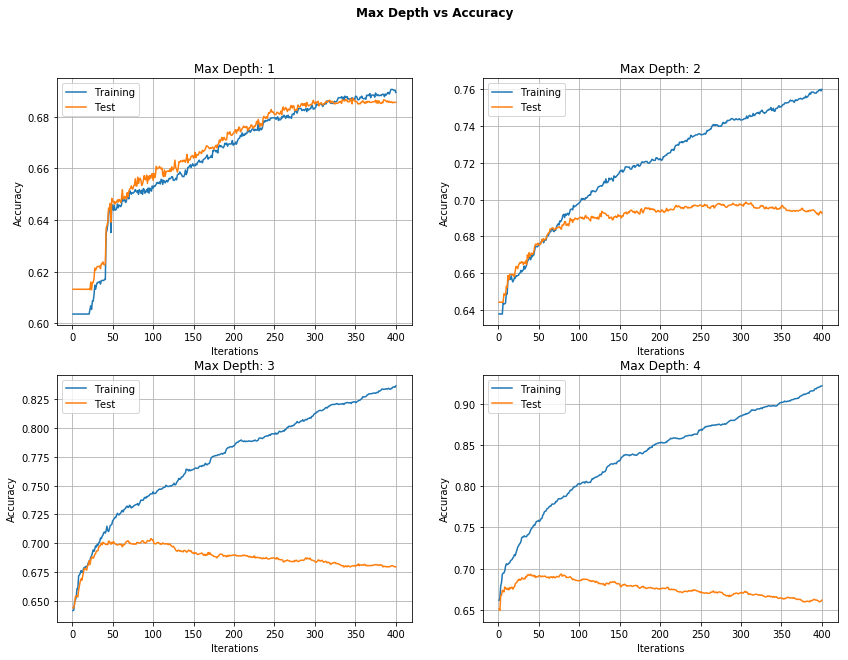

In [22]:
# Initialize figure and subplots
fig, ax = plt.subplots(2,2, figsize=(14,10))

# Plot for each depth
for depth in np.arange(1,5):
    
    # Initialize and fit the model for the given depth
    curr_model = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth=depth), n_estimators=400, learning_rate = 0.05)
    curr_model.fit(X_train, y_train)
    
    # calculate the row and column
    row = int(depth/3)
    col = (depth+1) % 2
    
    # Plot the Accuracy on the Trainining and Test Data
    ax[row, col].plot(np.arange(1,401), list(curr_model.staged_score(X_train, y_train)), label="Training")
    ax[row, col].plot(np.arange(1, 401), list(curr_model.staged_score(X_test, y_test)), label = "Test")
    
    # Add labels
    ax[row, col].legend()
    ax[row, col].set_title("Max Depth: {0}".format(depth))
    ax[row, col].set_xlabel("Iterations")
    ax[row, col].set_ylabel("Accuracy")
    ax[row, col].grid(True)

# Add figure title
fig.suptitle("Max Depth vs Accuracy", fontweight="bold");
    

----
**For a max depth of 1, the training and test accuracoes increase alongside each other throughout all 400 iterations up to an accuracy slightly greater than 0.68.<br>
For a max depth of 2, the test accuracy stops improving after 100 iterations at an accuracy score of about 0.685, while the training data continues improving, indicating overfitting.<br>
For a max depth of 3, the Test accuracy peaks at about 0.70 around 40 iterations, then begins to decrease as the training score increases.<br>
For a max depth of 4, the test accuracy peaks at a score of about 0.69 around 40 iterations and decreases.  The training score is much higher and continues to increase throughout all 400 iterations, indicating overfitting.**  

**4.3** Based on the plot from 4.2, what combination of base learner depth and number of iterations seems optimal? Why?


----
**A base learner depth of 4 with 40 iterations seems optimal, as the highest accuracy score on the test data is achieved with a base learner depth of 4, and the minimum number of iterations to achieve approximately the highest accuracy is about 40 iterations.**

**4.4** AdaBoost doesn't combine its sub-models via simple majority vote, or by averaging probabilities. What does it use instead, and why do you think that combination rule was chosen?

----
**AdaBoost combines its sub-models using weights, which helps prevent overfitting/fitting random variance for instances in the dataset that are harder to classify.  Using negative weights for classifiers with less than 50 % accuracy allows the sub-model to help increase the prediction accuracy in the final model, and using weights closer to 0 for classifiers with close to 50% accuracy prevents overfitting by using classifiers that contribute less to the final prediction.**

## Question 5 (18 pts): Ensembling
In this question we take the running theme of combining model to its extreme. So far, we have been combining the predictions of relatively bad models; in this section we'll combine several strong models and achieve our best accuracy yet.

We provide well-tuned models in the file `models.pkl`. The code below will read in this data for you. The model_dict object contains 5 tuned models, under the names "Ada", "KNN", "Logit", "QDA", and "RF".

**5.1**: Report each of the 5 tuned models' score on the test set, so that you can compare to these scores later.

**5.2**: Read in the fresh dataset `data/Higgs_tune.csv` Similar to 2.1, build `ensemble_tune` and `ensemble_test`, datasets containing each tuned model's prediction of P(this point belongs to class 1) for each of the tuning and test points.

**5.3**: Build a meta-model trained on `ensemble_tune` and predicting the tuning set labels (e.g., a LogisticRegression or RandomForest). Which model does your meta-model consider most important, and how well does your meta-model perform on the test set?

**5.4**: Augment the `ensemble_tune` and `ensemble_test` datasets with the columns from the original tuning and test data to form `augmented_tune` and `augmented_test`. Fit a decision tree model to this new tuning data (max depth 5, no mximum number of features).

**5.5**: How well does the meta-tree do on the test set? Why does training a decision tree on the combination of original data and model predictions perform so well?

**5.6**: Suggest one way to improve on the model above

In [23]:
# will produce a warning under most versions of SKlearn, but it should be OK to ignore
# if you get weird errors or the models all stink, let us know

import pickle
with open("data/models.pkl", 'rb') as infile:
    model_dict = pickle.load(infile)

**Answers**:

**5.1**: Report each model's score on the test set, so that you can compare to these scores later.

In [24]:
# Print the accuracy scores:
print("\033[1mAccuracy Scores\033[0m")

# Iterate through each model
for key in model_dict:
    print("\033[1m{0} Test:\033[0m {1: .4f}".format(key, np.mean(model_dict[key].predict(X_test) == y_test)))

Accuracy Scores
Ada Test:  0.6756
RF Test:  0.6748
Logit Test:  0.6384
QDA Test:  0.6330
KNN Test:  0.5774


**5.2**: Read in the fresh dataset `data/Higgs_tune.csv`.  Similar to 2.1, build `ensemble_tune` and `ensemble_test`, datasets containing each tuned model's prediction of P(this point belongs to class 1) for each of the tuning and test points.

In [25]:
# Read in the tuning data
data_tune = pd.read_csv("data/Higgs_tune.csv")

# Separate to X_tune, y_tune
X_tune = data_tune.iloc[:, data_tune.columns != 'class']
y_tune = data_tune['class'].values

# Initialize empty DataFrames to store the model predictions
ensemble_test = pd.DataFrame()
ensemble_tune = pd.DataFrame()

# Iterate through each model
for key in model_dict:

    # Store the model's predictions on the tuning data
    ensemble_tune["{0} model's predictions".format(key)] = model_dict[key].predict(X_tune)
    
    # Store the model's prediction on the test data
    ensemble_test["{0} model's predictions".format(key)] = model_dict[key].predict(X_test)

**5.3**: Build a meta-model trained on `ensemble_tune` and predicting the tuning set labels (e.g., a LogisticRegression or RandomForest). Which model does your meta-model consider most important, and how well does your meta-model perform on the test set?

In [26]:
# Initialize a Logistic Regression Model and fit it to the ensemble_tune and y_tune
lr_model = LogisticRegressionCV().fit(ensemble_tune, y_tune)

# Store the coefficients for each model's predictions
weights = lr_model.coef_[0]

# Display the coefficient/weight for each model
print("\033[1mWeights:\033[0m\n")
for index, key in enumerate(model_dict):
    print("\033[1m{0}:\033[0m {1}".format(key, weights[index]))

# Display the prediction accuracy on the test set
print("\n\033[1mTest Accuracy:\033[0m {0}".format(np.mean(lr_model.predict(ensemble_test) == y_test)))

Weights:

Ada: 0.5015042624225309
RF: 0.7286454231772533
Logit: 0.43668829697910083
QDA: 0.41026836519832377
KNN: 0.13740615410894894

Test Accuracy: 0.6798


----
**Meta-model considers RandomForest to be the most important as it has a significantly larger weight (0.729) than all other models (the next highest is 0.502).  The meta-model predicts the test data with an accuracy of 0.6798.**

----

**5.4**: Augment the `ensemble_tune` and `ensemble_test` datasets with the columns from the original tuning and test data to form `augmented_tune` and `augmented_test`. Fit a decision tree model to this new tuning data (max depth 5, no mximum number of features).

In [27]:
# Augment the dataframes to create augmented_tune and augmented_test
augmented_tune = ensemble_tune.join(X_tune)
augmented_test = ensemble_test.join(X_test)

# Store the new fitted model
aug_model = DecisionTreeClassifier(max_depth = 5).fit(augmented_tune, y_tune)

# Display the accuarcy scores for the tuning and test data
print("\033[1mTuning Score:\033[0m {0}".format(np.mean(aug_model.predict(augmented_tune) == y_tune)))
print("\033[1mTest Score:\033[0m {0}".format(np.mean(aug_model.predict(augmented_test) == y_test)))

Tuning Score: 0.737
Test Score: 0.6802


**5.5:** How well does the meta-tree do on the test set? Why does training a decision tree on the combination of original data and model predictions perform so well?

----
**The meta-tree performs similar to the meta-model on the test set (both around 0.68).  This may be due to the already strong influence of the Random Forest, which was already considered the the most important model in the meta-model and is composed of decision trees.  Thus the decision tree models' predictions on the original data are favored in both models.  The performances may be similar as the original data and the model predictions may be correlated.**

----

**5.6**: Suggest one way to improve on the model above

**One way to improve the model above may be to build ensemble_tune by bagging each model's predictions instead of tuning the model to just one sample.**

## Question 6 (12 pts): Understanding
This question is an overall test of your knowledge of this homework's material. You may need to refer to lecture notes and other material outside this homework to answer these questions.

<div class='exercise'> Question 6</div>
**6.1** How do ensembling, boosting, and bagging all relate: what is common to all three, and what is unique to each of them?

**6.2** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

**6.3** What is the impact of having too many trees/iterations in boosting and in bagging? In which instance is it worse to overshoot?

**6.4** Suppose you have 10,000 training observations and have selected (non-polynomial) linear regression as your base model. Which technique will help your model more, boosting or bagging? How does your choice (and boosting/bagging in general) tie to overfitting versus underfitting?

**Answers**:  
**6.1** How do ensembling, boosting, and bagging all relate: what is common to all three, and what is unique to each of them?

----
**Boosting  and bagging are both types of ensemble models, and thus since they are ensemble created through ensembling, the models are all formed through training and aggregating multiple sub-models for a preidction.  Each model thus provides us less interpretable information than a simple linear regression model would, but will also provide higher expressiveness and lower variance for complex functions and decision boundaries.  What is unique to bagging is bagging averages all of its sub-models and sums them without weights.  Boosting applies to weights to all of its sub-models before aggregating them before prediction.**

----

**6.2** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

----
**Bagging is better suite to parallelization, as all sub-models in bagging are to be made from different bootstrapped samples from the same data.  However, with boosting, each sub-model must be made iteratively as each model is made from the residuals of the sum of the previous models and their weights.**

----

**6.3** What is the impact of having too many trees/iterations in boosting and in bagging? In which instance is it worse to overshoot?

----
**Having too many trees/iterations in boosting leads to overfitting as random variance in the residuals is wrongly fit with trees.  Having too many trees in bagging just leads to inefficient compile time, as the model is still a mean of bootstrap models with the same bootstrapped sample size, just a larger amount of models.  It is thus worse to overshoot iterations in boosting.**

----

**6.4** Suppose you have 10,000 training examples and have selected (non-polynomial) linear regression as your base model. Which technique will help your model more, boosting or bagging? How does your choice (and boosting/bagging general) tie to overfitting versus underfitting?


----
**Bagging will help your mode more, as linear regression and boosting both use the same loss function, so aggregating linear models in boosting will lead to a model of the same predictive strength as the base model.  Only one training example would be used in boosting as well, as all subsquent iterations in boosting are based off of residuals produced of the previous model, which eventually ties back to the first iteration being fit on one sample of data.  Thus, to prevent underfitting, a bagging approach applied to the 10,000 training examples will be more predictive as it will average the trends found in all 10,000 training examples.** 

<hr style='height:2pt'>
## Question 7 (26 points): Neural Networks
Neural networks are, of course, a large and complex topic that cannot be covered in a single homework. Here we'll focus on the key idea of NNs: they are able to learn a mapping from example input data (of fixed size) to example output data (of fixed size). We'll also partially explore what patterns the neural network learns and how well they generalize.

In this question we'll see if Neural Networks can learn a (limited) version of the Fourier Transform. (The Fourier Transform takes in values from some function and returns a set of sine and cosine functions which, when added together, approximate the original function.)

In our specific problem, we'll try to teach a network to map from  a function's 1000 sample y-values to the four features of the sine and cosine waves that make up that function. Thus, the network is attempting to learn a mapping from a 1000-entry vector down to a 4-entry vector. Our X_train dataset is thus N by 1000 and our y_train is N by 4. 

We'll use 6 data files in this question:
- `sinewaves_X_train.npy` and `sinewaves_y_train.npy`: a (10,000 by 1,000) and (10,000 by 4) training dataset. Examples were generated by randomly selecting a,b,c,d in the interval [0,1] and building the curve $a\sin(b\,x) + c\cos(d\,x)$
- `sinewaves_X_test.npy` and `sinewaves_y_test.npy`: a (2,000 by 1,000) and (2,000 by 4) test dataset, generated in the same way as the training data
- `sinewaves_X_extended_test` and `sinewaves_y_extended_test`: a (9 by 1,000) and (9 by 4) test dataset, testing whether the network can generalize beyond the training data (e.g. to negative values of $a$)

**These datasets are read in to their respective variables for you.**

<div class='exercise'> Question 7</div>
**7.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve

**7.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced samples in $[0,10\pi]$ from the function $f(x) = 0.24\sin(0.533\,x) + 0.018\cos(0.558\,x)$. This pattern (y_train is the true parameters of the curve in X_train) will always hold.

**7.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

**7.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

**7.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of 0.2. You can train for longer if you wish- the fit tends to improve over time.

**7.6** Use the `plot_predictions` function to plot the model's predictions on `X_test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefficients that generated the data?

**7.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

**7.8** Is there something that stands out about the difficult examples, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

**Hint**:
- Keras's documentation and examples of a Sequential model are a good place to start.
- A strong model can achieve validation error of around 0.03 on this data and 0.02 is very good.

In [28]:
def plot_predictions(model, test_x, test_y, count=None):
    # Model - a Keras or SKlearn model that takes in (n,1000) training data and predicts (n,4) output data
    # test_x - a (n,1000) input dataset
    # test_y - a (n,4) output dataset
    # This function will plot the sine curves in the training data and those implied by the model's predictions.
    # It will also print the predicted and actual output values.
    
    #helper function that takes the n by 4 output and reverse-engineers 
    #the sine curves that output would create
    def y2x(y_data):
        #extract parameters
        a=y_data[:,0].reshape(-1,1)
        b=y_data[:,1].reshape(-1,1)
        c=y_data[:,2].reshape(-1,1)
        d=y_data[:,3].reshape(-1,1)

        #build the matching training data
        x_points = np.linspace(0,10*np.pi,1000)
        x_data = a*np.sin(np.outer(b,x_points)) + c*np.cos(np.outer(d,x_points))
        return x_data
    
    #if <20 examples, plot all. If more, just plot 5
    if count==None:
        if test_x.shape[0]>20:
            count=5
        else:
            count=test_x.shape[0]
    
    #build predictions
    predicted = model.predict(test_x)
    implied_x = y2x(predicted)
    for i in range(count):
        plt.plot(test_x[i,:],label='true')
        plt.plot(implied_x[i,:],label='predicted')
        plt.legend()
        plt.ylim(-2.1,2.1)
        plt.xlabel("x value")
        plt.xlabel("y value")
        plt.title("Curves using the Neural Network's Approximate Fourier Transform")
        plt.show()
        print("true:", test_y[i,:])
        print("predicted:", predicted[i,:])
    
    

In [29]:
X_train = np.load('data/sinewaves_X_train.npy')
y_train = np.load('data/sinewaves_y_train.npy')

X_test = np.load('data/sinewaves_X_test.npy')
y_test = np.load('data/sinewaves_y_test.npy')

X_extended_test = np.load('data/sinewaves_X_extended_test.npy')
y_extended_test = np.load('data/sinewaves_y_extended_test.npy')

**Answers**:  
**7.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve

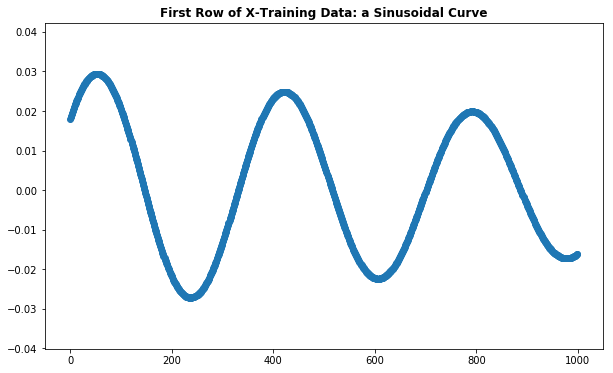

In [30]:
# Initialize the figure and subplot
fig, ax = plt.subplots(1,1, figsize=(10,6))

# Store the first row of data
first_row = X_train[0, :]

# Plot the data
ax.scatter(np.arange(0, len(first_row)), first_row)

# Add Labels
ax.set_title("First Row of X-Training Data: a Sinusoidal Curve", fontweight="bold");

**7.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced points in $[0,10\pi]$ from the function $f(x) = 0.24\sin(0.533\,x) + 0.018\cos(0.558\,x)$...

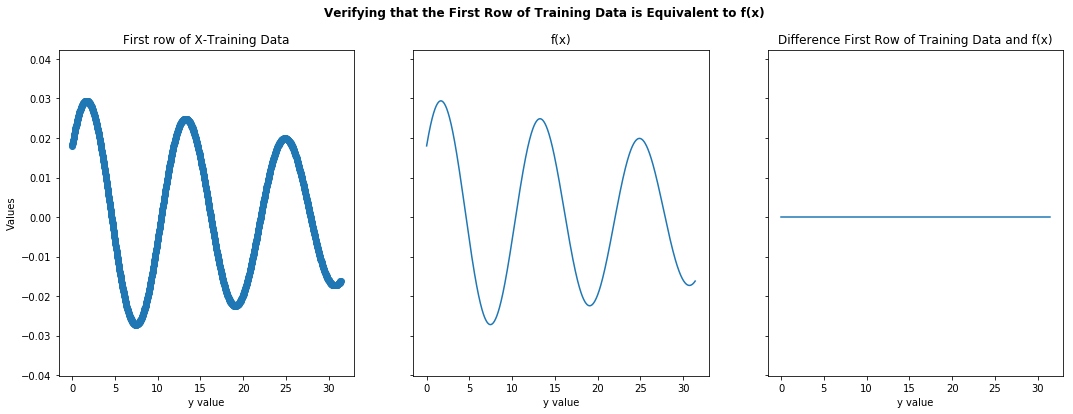

In [38]:
# Initialize the figure and subplots
fig, ax = plt.subplots(1,3, figsize=(18,6), sharey=True)

# get pi
pi = np.deg2rad([180])[0]

# Store x
x = np.linspace(0, 10*pi, 1000)

# Store the function values
function_x = 0.024 * np.sin(0.533*x) + 0.018*np.cos(0.558 *x)

# Plot the Training Data
ax[0].scatter(x, first_row)

# Plot the Function Values
ax[1].plot(x, function_x)

# Plot the Difference of the Values
ax[2].plot(x, first_row - function_x);

# Add Labels
ax[0].set_title("First row of X-Training Data")
ax[1].set_title("f(x)")
ax[2].set_title("Difference First Row of Training Data and f(x)")
ax[0].set_ylabel("Values")
ax[0].set_xlabel("y value")
ax[1].set_xlabel("y value")
ax[2].set_xlabel("y value")
fig.suptitle("Verifying that the First Row of Training Data is Equivalent to f(x)", fontweight="bold");

**7.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

In [32]:
# Initialize a model with 4 layers and 1 node for every 5 in the previous layer  
nn_model = Sequential([
    Dense(500, input_shape=(1000,), activation='relu'),
    Dense(100, activation='relu'),
    Dense(20, activation='relu'),
    Dense(4, activation='relu')
])

**7.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

In [39]:
# Compile the model
nn_model.compile(loss='mean_absolute_error', optimizer='adam')

# Print the summary
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 84        
Total params: 552,704
Trainable params: 552,704
Non-trainable params: 0
_________________________________________________________________


----
**The first layer in the network has the product of (number of inputs + 1) and (number of outputs) parameters.  This is because for each of the 500 nodes being outputted, 1000 inputs are used, and for each unit of outputs, one bias paramter is included.  Thus, the first layer in the neural network has 1000* 500 + 1*500 = 500500 parameters.**


**7.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of .2. You can train for longer if you wish- the fit tends to improve over time.

In [34]:
# Fir the model to the data
nn_model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_split=0.2);

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 5s 590us/step - loss: 0.1985 - val_loss: 0.1175
Epoch 2/50
8000/8000 [==============================] - 4s 486us/step - loss: 0.1029 - val_loss: 0.0955
Epoch 3/50
8000/8000 [==============================] - 4s 513us/step - loss: 0.0811 - val_loss: 0.0763
Epoch 4/50
8000/8000 [==============================] - 4s 498us/step - loss: 0.0703 - val_loss: 0.0676
Epoch 5/50
8000/8000 [==============================] - 4s 497us/step - loss: 0.0641 - val_loss: 0.0612
Epoch 6/50
8000/8000 [==============================] - 4s 509us/step - loss: 0.0603 - val_loss: 0.0611
Epoch 7/50
8000/8000 [==============================] - 4s 486us/step - loss: 0.0567 - val_loss: 0.0575
Epoch 8/50
8000/8000 [==============================] - 4s 493us/step - loss: 0.0529 - val_loss: 0.0534
Epoch 9/50
8000/8000 [==============================] - 4s 496us/step - loss: 0.0507 - val_loss: 0.0487
Epoch 10/50
8000

**7.6** Use the `plot_predictions` function to plot the model's predictions on `X-test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefecients that generated the data?

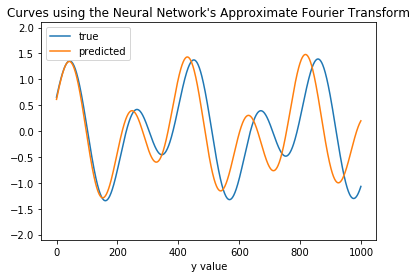

true: [0.86199664 0.98175913 0.65523998 0.4870337 ]
predicted: [0.8766409  1.0370221  0.6128097  0.49551597]


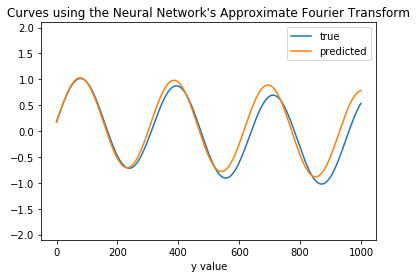

true: [0.8406355  0.63159555 0.18328701 0.11174618]
predicted: [0.85975957 0.6470625  0.17024049 0.06417534]


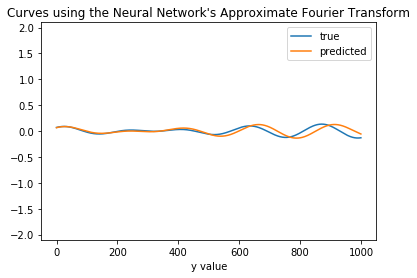

true: [0.06591224 0.75183886 0.06986143 0.91352303]
predicted: [0.07014205 0.69785255 0.06595432 0.8872793 ]


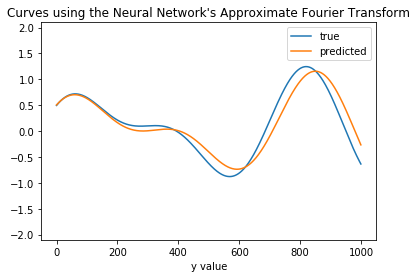

true: [0.75610725 0.30861152 0.49522059 0.48394499]
predicted: [0.69327694 0.30437556 0.5051378  0.46100664]


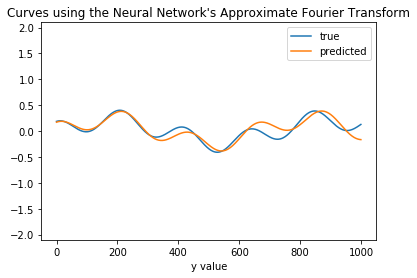

true: [0.2229353  0.27885697 0.18696198 0.94846283]
predicted: [0.23448199 0.3007226  0.17174992 0.9120406 ]
2000/2000 [==============================] - 0s 92us/step

Overall Loss on Test Set: 0.027336516320705415


In [35]:
# Plot the predictions on X-test to the trye values in y-test
plot_predictions(nn_model, X_test, y_test)

# Print the overall loss on the test set
print("\n\033[1mOverall Loss on Test Set:\033[0m {0}".format(nn_model.evaluate(X_test, y_test)))

----
**The model's overall loss on the test is 0.0273, meaning that the model predicts the test data with >97% accuracy.  The model performs fairly well on most of the displayed unseen data, however for data for where the amplitude coefficient for one of sine and cosine is large and the other is much smaller, the model performs much better visually.  This makes sense intuitively, as then the model prediction can align more with one sinusoidal function rather than a sum of two sinusoidal functions, which is more complex.**

----

**7.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

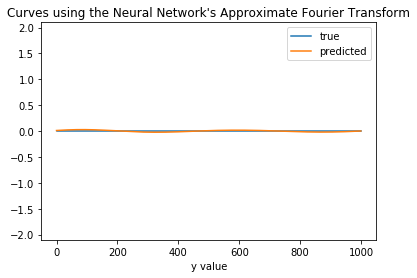

true: [0. 0. 0. 0.]
predicted: [0.02849145 0.4141574  0.01126588 0.48950827]


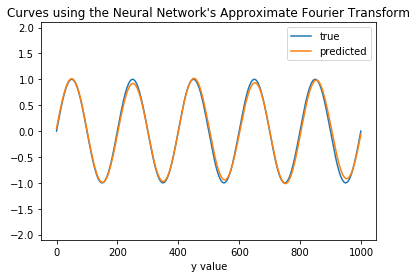

true: [1. 1. 0. 0.]
predicted: [0.96954644 0.9965707  0.05119791 0.42147288]


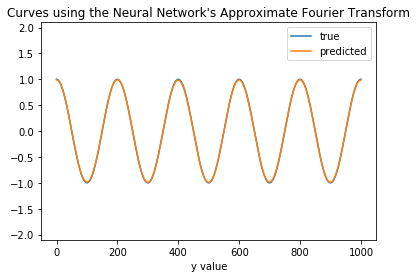

true: [0. 0. 1. 1.]
predicted: [0.00459553 0.33444706 0.988226   1.0002952 ]


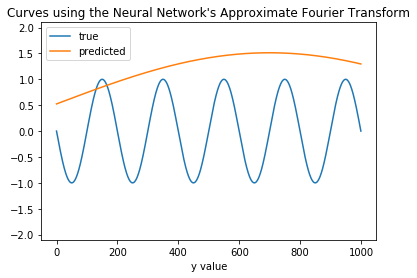

true: [-1.  1.  0.  0.]
predicted: [0.98812747 0.07147479 0.52466446 0.        ]


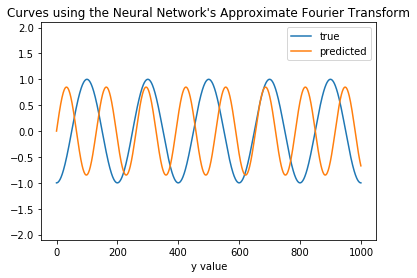

true: [ 0.  0. -1.  1.]
predicted: [0.84949505 1.5290029  0.         0.        ]


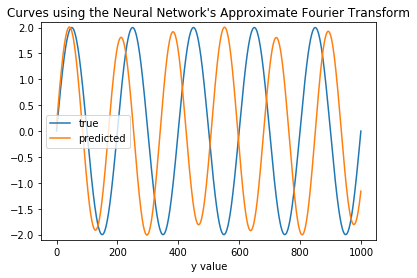

true: [2. 1. 0. 0.]
predicted: [1.9115026  1.176795   0.114459   0.39710292]


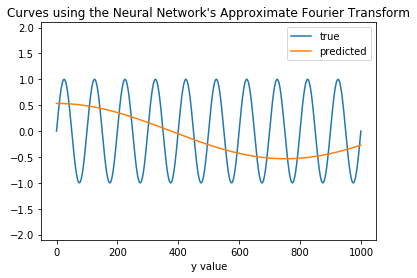

true: [1. 2. 0. 0.]
predicted: [0.         0.         0.5343006  0.13301265]


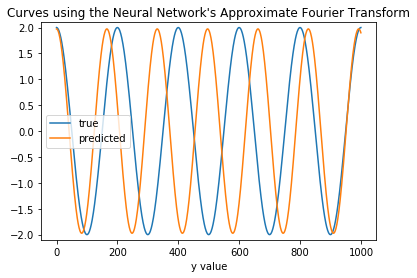

true: [0. 0. 2. 1.]
predicted: [0.         0.33409384 1.9730753  1.2087526 ]


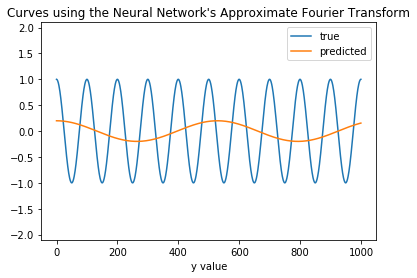

true: [0. 0. 1. 2.]
predicted: [1.0996338  0.         0.19918695 0.3782246 ]
9/9 [==============================] - 0s 362us/step

Overall Loss on Test Set: 0.5043628811836243


In [36]:
# Plot the predictions on X-extended-test to the true values in y-extended-test
plot_predictions(nn_model, X_extended_test, y_extended_test)

# Print the overall loss on the extended test set
print("\n\033[1mOverall Loss on Test Set:\033[0m {0}".format(nn_model.evaluate(X_extended_test, y_extended_test)))

----
**While for the first three examples the model appears to perform well on, the model poors quite poorly on the other examples.  The overall loss on the extended test set is 0.504, which is significantly worse than that on the test set. The model does best on examples where all of the coefficients are between 0 and 1.  For all other models, ones where the coefficients are also negative or greater than 1, the predictions are quite poor.  Perhaps the worst performance can be seen on the function with the coefficients [-1,1,0,0] where instead of a negative sine function, a positive sine function with a really large period (small period coefficient) was displayed.  It would better help for the understanding of the model's performance if a train/test pair was added that displayed negative coefficients for both the amplitude and period coefficients, as that case was never displayed in the graphs.  However, the training data for the model did not contain negative coefficients, so it can be expected that the model would perform poorly on any data with negative coefficients, as that would be extrapolation of the model. The model is also extrapolated to predict for coefficients greater than 1 in value, which were not included in the model's training set.**

**7.8** Is there something that stands out about the difficult observations, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

----
**The data from the difficult observations included negative coefficients and coefficients greater than one, while the data that the model was trained on only containied coefficients between 0 and 1.  Also, the data for the difficult observations all appear to be ordinal, while the data the model was trained on was continuous.  Thus the model did learn the mapping of the sample y-values of data to the four features of the sine and cosine waves that make up that function, but only for data similar in format to that of the training data.  I would not say the model is not overfit or underfit, as the model performs well on what it was trained to predict as shown in the X-test and y-test predictions.  However, the model was not trained to predict for the type of data seen in the extended test sets, thus why the performance was so low.  If it was desired for the model to predict well for the extended test data, that type of data would need to have been included in the training data, not a set of data with a different domain.**
